In [1]:
import json
import os
import numpy as np
import tensorflow as tf
import string
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,Dense, Embedding, LSTM,Flatten,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

In [2]:
##Inicjalizacja akceleratora GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#Wczytanie zbioru danych pliku json
df=pd.read_json('C:/Users/komej/Downloads/News_Category.json',lines=True)

In [4]:
df.head(15)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26


In [5]:
#Tworzenie unikalnej liczby dla każdej kategorii
mapping=dict(enumerate(df['category'].unique()))
label_map={value:key for key,value in mapping.items()}

In [6]:
label_map

{'CRIME': 0,
 'ENTERTAINMENT': 1,
 'WORLD NEWS': 2,
 'IMPACT': 3,
 'POLITICS': 4,
 'WEIRD NEWS': 5,
 'BLACK VOICES': 6,
 'WOMEN': 7,
 'COMEDY': 8,
 'QUEER VOICES': 9,
 'SPORTS': 10,
 'BUSINESS': 11,
 'TRAVEL': 12,
 'MEDIA': 13,
 'TECH': 14,
 'RELIGION': 15,
 'SCIENCE': 16,
 'LATINO VOICES': 17,
 'EDUCATION': 18,
 'COLLEGE': 19,
 'PARENTS': 20,
 'ARTS & CULTURE': 21,
 'STYLE': 22,
 'GREEN': 23,
 'TASTE': 24,
 'HEALTHY LIVING': 25,
 'THE WORLDPOST': 26,
 'GOOD NEWS': 27,
 'WORLDPOST': 28,
 'FIFTY': 29,
 'ARTS': 30,
 'WELLNESS': 31,
 'PARENTING': 32,
 'HOME & LIVING': 33,
 'STYLE & BEAUTY': 34,
 'DIVORCE': 35,
 'WEDDINGS': 36,
 'FOOD & DRINK': 37,
 'MONEY': 38,
 'ENVIRONMENT': 39,
 'CULTURE & ARTS': 40}

In [7]:
df['category']=df['category'].replace(label_map)

In [8]:
#Funkcja dzięki której z tekstu usuwana jest interpunkcja
def remove_punct(text):
    transaltor=str.maketrans("","",string.punctuation)
    return text.translate(transaltor)

In [9]:
#Funkcja która liczy wszystkie słowa
def counter_words(text):
    count=Counter()
    for txt in text.values:
        for word in txt.split():
            count[word] +=1
    return count
counter=counter_words(df.headline)

In [10]:
counter

Counter({'There': 591,
         'Were': 661,
         '2': 850,
         'Mass': 249,
         'Shootings': 105,
         'In': 24144,
         'Texas': 566,
         'Last': 744,
         'Week,': 89,
         'But': 1923,
         'Only': 793,
         '1': 514,
         'On': 13644,
         'TV': 688,
         'Will': 4162,
         'Smith': 226,
         'Joins': 169,
         'Diplo': 5,
         'And': 15140,
         'Nicky': 7,
         'Jam': 49,
         'For': 18790,
         'The': 47807,
         '2018': 174,
         'World': 2303,
         "Cup's": 4,
         'Official': 271,
         'Song': 331,
         'Hugh': 65,
         'Grant': 31,
         'Marries': 50,
         'First': 2511,
         'Time': 2157,
         'At': 7016,
         'Age': 451,
         '57': 15,
         'Jim': 133,
         'Carrey': 22,
         'Blasts': 151,
         "'Castrato'": 1,
         'Adam': 178,
         'Schiff': 8,
         'Democrats': 713,
         'New': 8400,
         'Artwor

In [11]:
num_unique_words=len(counter)

In [12]:
num_unique_words

119488

In [13]:
df['headline']=df.headline.map(remove_punct)

In [14]:
#Dzielenie zbioru danych na część przeznaczoną do trenowania sieci i część do jej późniejszego oceniania 
train_size=int(df.shape[0]*0.9)

train_df=df[:train_size]
val_df=df[train_size:]

train_sentences=train_df.headline.to_numpy()
train_labels=train_df.category.to_numpy()
val_sentences=val_df.headline.to_numpy()
val_labels=val_df.category.to_numpy()

In [15]:
#W tym miejscu jest tworzony indeks słownictwa, gdzie każdy wyraz ma przypisaną unikalną liczbe
tokenizer=Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)
word_index=tokenizer.word_index


In [16]:
#Zamienia tekst na sekwencję liczb
train_sequences=tokenizer.texts_to_sequences(train_sentences)
val_sequences=tokenizer.texts_to_sequences(val_sentences)


In [17]:
#Zapewnia wszystkim sekwencjom jednakową długość
train_padd=pad_sequences(train_sequences,padding='post',truncating='post',maxlen=50)
val_padd=pad_sequences(val_sequences,padding='post',truncating='post',maxlen=50)

In [18]:
num_cls=len(label_map)

In [40]:
inp=Input(shape=(train_padd[1].shape))
x1=Embedding(num_unique_words,32)(inp)
x2=LSTM(64,return_sequences=True)(x1)
x3=LSTM(64,return_sequences=True)(x2)
x4=Flatten()(x3)
d1=Dense(100,activation='relu')(x4)
dr=Dropout(0.2)(d1)
d2=Dense(64,activation='relu')(dr)
dr2=Dropout(0.2)(d2)
out=Dense(num_cls,activation='softmax')(dr2)

In [41]:
model=Model(inp,out,name='NLP3')

In [42]:
model.summary()

Model: "NLP3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 32)            3823616   
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            24832     
                                                                 
 lstm_5 (LSTM)               (None, 50, 64)            33024     
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               320100    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0      

In [43]:
#Monitorowanie spadku funkcji aby uzyskać jak najlepsze wyniki
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=4,verbose=1,mode='auto',restore_best_weights=True)

In [44]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

In [45]:
history=model.fit(train_padd,train_labels,epochs=15,verbose=2,validation_split=0.1,callbacks=[monitor])

Epoch 1/15
5085/5085 - 67s - loss: 2.9809 - accuracy: 0.2347 - val_loss: 2.9732 - val_accuracy: 0.2456 - 67s/epoch - 13ms/step
Epoch 2/15
5085/5085 - 61s - loss: 2.5651 - accuracy: 0.3127 - val_loss: 2.7629 - val_accuracy: 0.3150 - 61s/epoch - 12ms/step
Epoch 3/15
5085/5085 - 59s - loss: 2.3820 - accuracy: 0.3540 - val_loss: 2.6255 - val_accuracy: 0.3453 - 59s/epoch - 12ms/step
Epoch 4/15
5085/5085 - 61s - loss: 2.1925 - accuracy: 0.4018 - val_loss: 2.3891 - val_accuracy: 0.4223 - 61s/epoch - 12ms/step
Epoch 5/15
5085/5085 - 61s - loss: 2.0098 - accuracy: 0.4480 - val_loss: 2.2674 - val_accuracy: 0.4790 - 61s/epoch - 12ms/step
Epoch 6/15
5085/5085 - 61s - loss: 1.8887 - accuracy: 0.4790 - val_loss: 2.2886 - val_accuracy: 0.4689 - 61s/epoch - 12ms/step
Epoch 7/15
5085/5085 - 62s - loss: 1.7849 - accuracy: 0.5059 - val_loss: 2.1522 - val_accuracy: 0.5113 - 62s/epoch - 12ms/step
Epoch 8/15
5085/5085 - 62s - loss: 1.6959 - accuracy: 0.5260 - val_loss: 2.0594 - val_accuracy: 0.5207 - 62s/ep

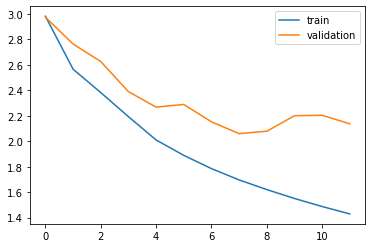

In [46]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()

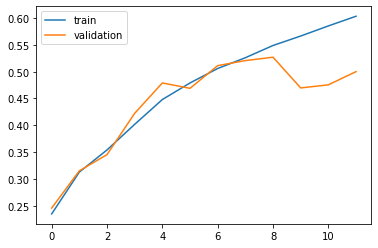

In [47]:
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()

In [48]:
#Dokładność sieci na zbiorze testowym
test_model=model.evaluate(val_padd,val_labels,verbose=1)

628/628 [==============================] - 3s 5ms/step - loss: 2.2201 - accuracy: 0.4996


In [49]:
sample=["One of victim was injured by robber"]
seq=tokenizer.texts_to_sequences(sample)
pad=pad_sequences(seq,padding='post',maxlen=50,truncating='post')
score=model.predict(pad)
print(score)

[[6.38702452e-01 2.23483541e-03 1.04171485e-02 8.95997509e-03
  1.58550516e-02 1.41678482e-01 1.00799631e-02 1.41258072e-03
  2.14930740e-03 1.83120966e-02 6.64108014e-03 8.92803655e-04
  3.30747629e-04 1.36921147e-03 3.04170628e-03 1.96082070e-02
  2.18437202e-02 2.73194234e-03 4.72883024e-04 5.95365046e-03
  9.44850559e-04 5.55165438e-03 3.10946380e-05 1.43405842e-02
  2.04276894e-05 2.66706804e-04 6.97581656e-03 4.30004299e-02
  2.65968707e-03 9.14590928e-05 2.78079510e-03 5.99028252e-04
  5.93096251e-04 2.04141161e-05 3.43015745e-05 1.24517363e-03
  4.29410161e-03 6.59290981e-06 1.02245494e-05 2.22617178e-03
  1.61956961e-03]]


In [50]:
m=np.argmax(score)

In [51]:
score[0,10]

0.00664108

In [52]:
m

0

In [66]:
model.save('C:/Users/komej/Downloads/category1.h5')